## UC2 Experiments on Meta-Learning and Dataset Exploration

In [4]:
import sys
sys.path.append("../represent")

import os
import pandas as pd
import rasterio
import numpy as np
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from torchvision.models import resnet18
import torch.nn.functional as F
from torchvision.models import resnet18
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch

from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

!pip install -U git+https://github.com/marccoru/meteor.git -q
    
from meteor import METEOR
from meteor import models
import torch

from tqdm.auto import tqdm

DATA_PATH = "/data/RepreSent/UC2" # former "/data/lloyd/RepreSent/UC2"

# classes that are present in both train and test partitions
keep_classes = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 22, 23, 24])

from represent.datamodules.uc2_landcover_datamodule import UC2LandCoverDataModule, UC2LandCoverDataset, CLASSES, sample_task
from represent.datamodules.uc2_landcover_datamodule import load_samples, CLASSNAMES, COARSE_CLASSES

def plot_confusion_matrix(y_true, y_pred):
    present_classes = np.unique(y_true)
    present_classnames = [CLASSNAMES[c] for c in present_classes]

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize="true", labels=present_classes)
    cm_all = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=None, labels=present_classes)

    fig, ax = plt.subplots(figsize=(10,10))

    sc = ax.imshow(cm, cmap="Blues", vmin=0, vmax=1)
    ax.grid("off")
    ax.set_xticks(np.arange(len(present_classes)))
    ax.set_yticks(np.arange(len(present_classes)))

    ax.set_xticklabels(present_classnames, rotation="30", ha="right")
    ax.set_yticklabels(present_classnames)

    for r in range(cm.shape[0]):
        for c in range(cm.shape[1]):
            v = f"{cm_all[c,r]}"
            v = f"{v[:-3]}k" if len(v) > 3 else v
            color = "black" if cm[c,r] < 0.5 else "white"
            ax.text(r,c,v, ha="center", va="center", color=color)

    ax.grid(False)

    ax.set_xlabel("predicted", labelpad=-600)
    ax.set_ylabel("true", loc="center", labelpad=-690)

    cbar = fig.colorbar(sc, ax=ax, location='right', anchor=(0, 0.3), shrink=0.9)

    cbar.ax.set_title('recall')
    
    return fig

def split_support_query(ds, shots, at_least_n_queries=1, random_state=0, classcolumn="majorityclass"):
    classes, counts = np.unique(ds.index[classcolumn], return_counts=True)
    classes = classes[counts > 2]  # we need at least shots + 1 + at_least_n_queries samples of each class in the dataset

    classes, counts = np.unique(ds.index[classcolumn], return_counts=True)
    
    supports = []
    queries = []
    for c in classes:
        samples = ds.index.loc[ds.index[classcolumn] == c].reset_index()
        
        N_samples = shots if len(samples) > shots else len(samples) - 1 # keep at least one sample for query 
        support = samples.sample(N_samples, random_state=random_state, replace=False)
        query = samples.drop(support.index)
        supports.append(support)
        queries.append(query)
    supports = pd.concat(supports)
    queries = pd.concat(queries)

    return supports, queries
    
CLASSNAMES


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


{1: 'River',
 2: 'Tree Plantations Large',
 3: 'Forest Closed',
 4: 'Forest Open',
 5: 'Shrubs Closed',
 6: 'Grasslands Closed Acquatic',
 7: 'Urban - Built Up',
 8: 'Shrubs Open',
 9: 'Grasslands Closed',
 10: 'Agriculture flooded - Graminoid Small',
 11: 'Herbaceous Crops Small',
 12: 'Shrub Crops Small',
 13: 'Urban - Not Built Up',
 14: 'Herbaceous Crops Large',
 15: 'Shrub Crops',
 16: 'Shrubs Open Acquatic',
 17: 'Bare Area(s)',
 18: 'Shrubs Closed Acquatic',
 19: 'Lake',
 20: 'Tree Orchard Small',
 21: 'Grasslands Open',
 22: 'Tree Orchard Large',
 23: 'Forest Open Acquatic',
 24: 'Forest Closed Acquatic',
 25: 'Tree Plantations Small',
 26: 'Agriculture flooded - Graminoid Large'}

## Determine the intersection

In [5]:
train_ds = UC2LandCoverDataset(root=DATA_PATH, partition="Train", 
                               segmentation=False, simplified_classes=False, image_size=610)
test_ds = UC2LandCoverDataset(root=DATA_PATH, partition="Test", 
                               segmentation=False, simplified_classes=False, image_size=610)
len(train_ds.index.majorityclass.unique()), len(test_ds.index.majorityclass.unique())

a = set(train_ds.index.majorityclass.unique())
b = set(test_ds.index.majorityclass.unique())
a.intersection(b)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 22, 23, 24}

In [6]:
len(train_ds), len(test_ds)

(679206, 128862)

## Label Distribution Test Set

Text(0, 0.5, 'frequency')

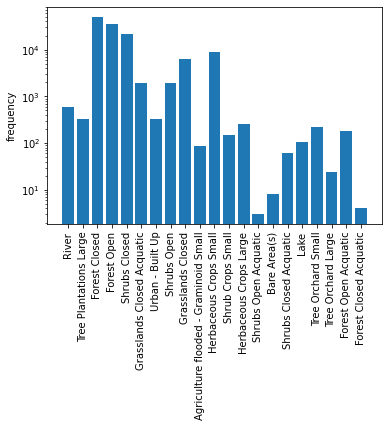

In [8]:
test_ds = UC2LandCoverDataset(root=DATA_PATH, partition="Test", 
                               segmentation=False, keep_classes=keep_classes, simplified_classes=False, image_size=610)
index = pd.concat([test_ds.index])

classes,counts = np.unique(index.majorityclass, return_counts=True)

fig, ax = plt.subplots(1,1, sharex=True)
ax.bar(np.arange(len(classes)),counts)
ax.set_xticks(np.arange(len(classes)))
ax.set_xticklabels([CLASSNAMES[c] for c in classes], rotation=90)
ax.set_yscale('log')
ax.set_ylabel("frequency")

## Label distribution combined

Text(0, 0.5, 'frequency')

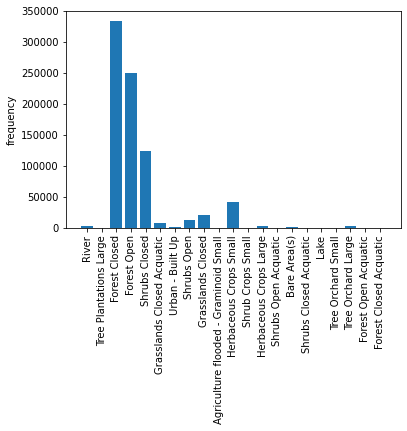

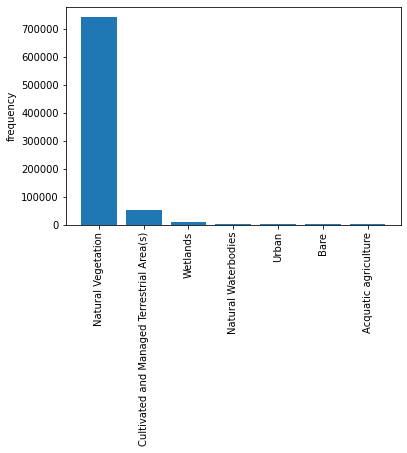

In [10]:
import matplotlib.pyplot as plt

train_ds = UC2LandCoverDataset(root=DATA_PATH, partition="Train", 
                               segmentation=False, keep_classes=keep_classes, simplified_classes=False, image_size=610)
test_ds = UC2LandCoverDataset(root=DATA_PATH, partition="Test", 
                               segmentation=False, keep_classes=keep_classes, simplified_classes=False, image_size=610)
index = pd.concat([test_ds.index, train_ds.index])

classes,counts = np.unique(index.majorityclass, return_counts=True)

fig, ax = plt.subplots()
ax.bar(np.arange(len(classes)),counts)
ax.set_xticks(np.arange(len(classes)))
ax.set_xticklabels([CLASSNAMES[c] for c in classes], rotation=90)
#ax.set_yscale('log')
ax.set_ylabel("frequency")

classes,counts = np.unique(index.majorityclass_coarse, return_counts=True)

fig, ax = plt.subplots()
ax.bar(np.arange(len(classes)),counts)
ax.set_xticks(np.arange(len(classes)))
ax.set_xticklabels([COARSE_CLASSES[c] for c in classes], rotation=90)
#ax.set_yscale('log')
ax.set_ylabel("frequency")

## Meta-Learning one-vs-all classification

In [11]:

def get_data(shots, keep_classes, limit_test_samples=None):

    train_ds = UC2LandCoverDataset(root=DATA_PATH, partition="Train", 
                                   segmentation=False, keep_classes=keep_classes, 
                                   simplified_classes=False, image_size=610)

    supports, queries = split_support_query(train_ds, shots)
    X_train, y_train = load_samples(train_ds, supports)

    keep_classes = np.array(y_train.unique()) # only consider classes that are also in the training set
    test_ds = UC2LandCoverDataset(root=DATA_PATH, partition="Test", image_size=610,
                                  segmentation=False, keep_classes=keep_classes, simplified_classes=False)

    test_ds_index = test_ds.index.reset_index()
    
    if limit_test_samples is not None:
        test_ds_index = test_ds_index.sample(limit_test_samples)
    
    # test set from the test area
    X_test, y_test = load_samples(test_ds, test_ds_index)
    
    return X_train, y_train, X_test, y_test


## Class examples

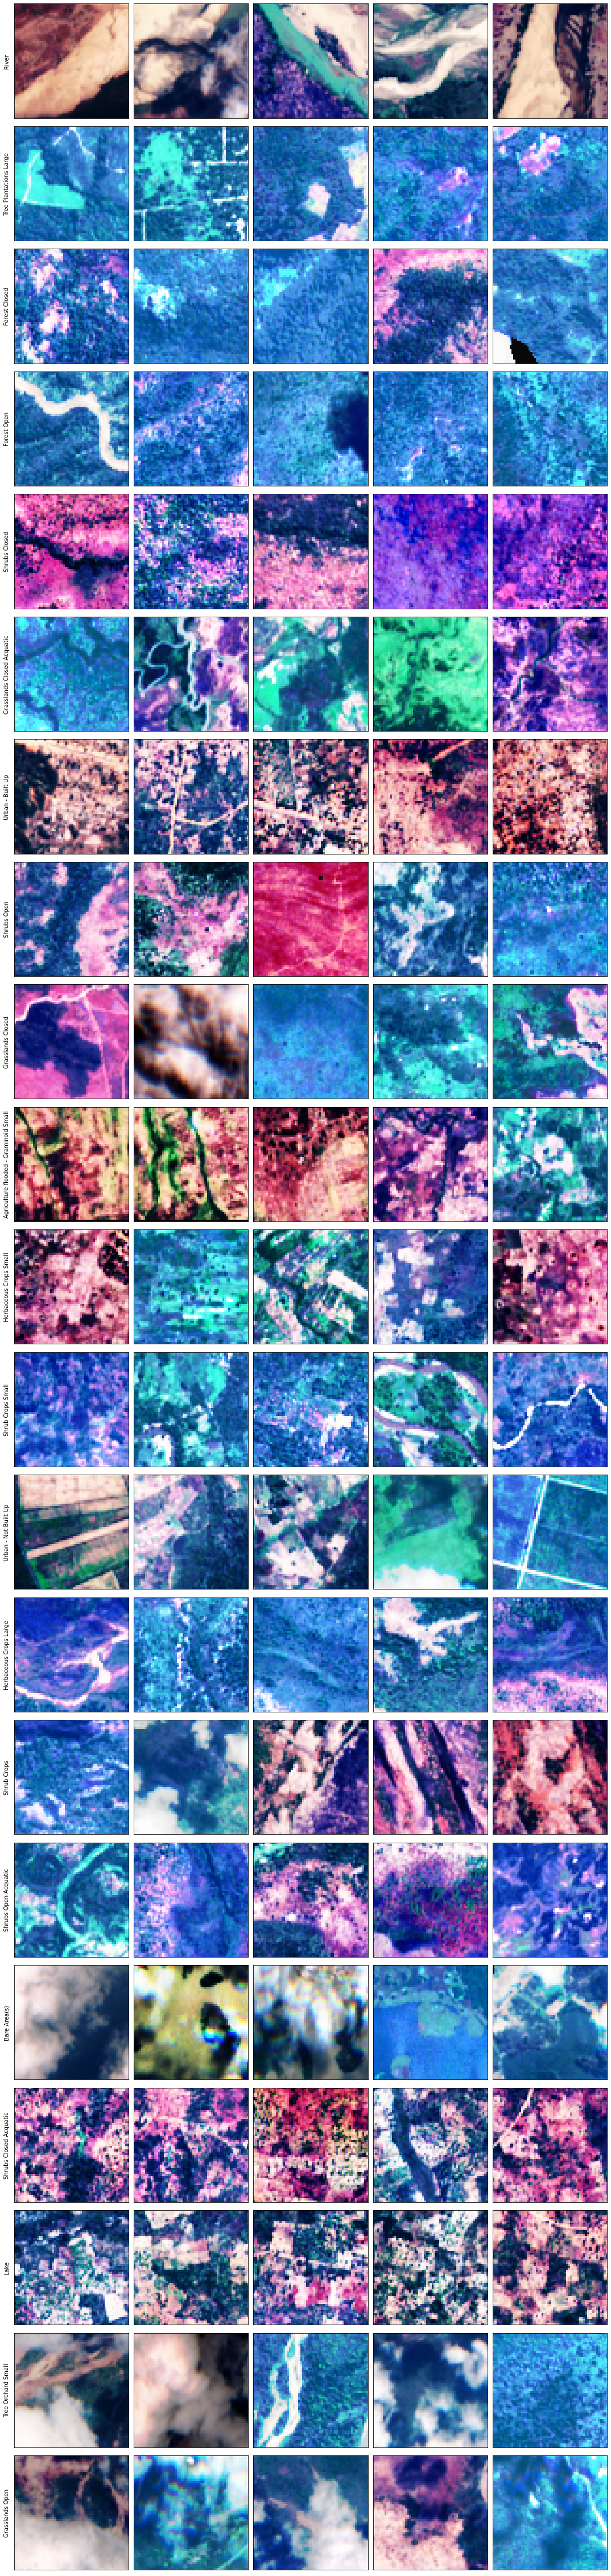

In [12]:
from skimage.exposure import equalize_hist

shots = 5

present_classes = keep_classes

X_train, y_train, _, _ = get_data(shots, keep_classes, limit_test_samples=1)

fig, axs = plt.subplots(len(present_classes), shots, figsize=(3*shots,3*len(present_classes)), sharey=True)

for i, (ax, X, y) in enumerate(zip(axs.reshape(-1), X_train, y_train)):

    ax.imshow(equalize_hist(X[np.array([3,2,1])].numpy()).transpose(1,2,0))
    #ax.set_title(f"{y}")
    ax.set_xticks([])
    ax.set_yticks([])
    
    if i % shots == 0:
        ax.set_ylabel(list(CLASSNAMES.values())[int(y)])
        
plt.grid(visible=False)
plt.tight_layout()

## Train and Test the MAML model

Train and test the Maml model with 
`uc2_evaluate_maml.py`

summary of shots and dataset sizes

In [13]:
for shots in [5,10,100,500,1000,5000]:
    train_ds = UC2LandCoverDataset(root="/data/RepreSent/UC2", partition="Train", 
                                   segmentation=False, keep_classes=keep_classes, 
                                   simplified_classes=False, image_size=610)

    supports, queries = split_support_query(train_ds, shots)
    #X_train, y_train = load_samples(train_ds, supports)

    N = supports.shape[0]
    print(f"{shots}-shots: {N} samples ({N/len(train_ds)*100:.2f} %)")

5-shots: 105 samples (0.02 %)
10-shots: 210 samples (0.03 %)
100-shots: 1966 samples (0.29 %)
500-shots: 8050 samples (1.19 %)
1000-shots: 14064 samples (2.07 %)
5000-shots: 48960 samples (7.21 %)


## Calculate number of gradient steps with the Coupons Collectors Problem



In [14]:
from math import log

def H(n):
    """Returns an approximate value of n-th harmonic number.

       http://en.wikipedia.org/wiki/Harmonic_number
    """
    # Euler-Mascheroni constant
    gamma = 0.57721566490153286060651209008240243104215933593992
    return gamma + log(n) + 0.5/n - 1./(12*n**2) + 1./(120*n**4)

def num_draws(n, k=0):
    return n*H(n-k)

def calculate_gradient_steps(N, batchsize, captured_percentile=0.9):
    k = N-int(N*captured_percentile)
    draws = num_draws(N,k)
    return int(draws/batchsize)

gradient_steps = calculate_gradient_steps(50000, 256, captured_percentile=2)
np.max([gradient_steps, 200])


2361

model trained with `uc2_evaluate_maml.py`, too big to be committed (6GB)

In [17]:
import meteor
checkpoint_file = "/data/RepreSent/UC2/results/500-shots-293-gradientsteps/uc2_maml_finetuned_shots500_293.pth"

# initialize
batch_size = 64
subset_bands = ["S2B1", "S2B2", "S2B3", "S2B4", "S2B5", "S2B6", "S2B7", "S2B8", "S2B8A", "S2B9", "S2B10",
                        "S2B11", "S2B12"]
basemodel = meteor.models.get_model("maml_resnet12", subset_bands=subset_bands)
taskmodel = METEOR(basemodel, verbose=True, device="cuda", gradient_steps=gradient_steps, mode="one_vs_one", batch_size=batch_size)

# load from checkpoint
taskmodel.params = torch.load(checkpoint_file)["params"]
taskmodel.labels = torch.load(checkpoint_file)["labels"]

In [18]:
test_ds = UC2LandCoverDataset(root="/data/RepreSent/UC2", partition="Test", 
                               segmentation=False, keep_classes=keep_classes, simplified_classes=False, 
                              image_size=610)

# get a single test sample for the plots later

idx = 5

x,y = test_ds[idx]
x = x.unsqueeze(0)

from collections import OrderedDict

## Prediction of a single sample

this function is a modification of taskmodel.fit where the internal scores are kept to be plotted later

In [19]:

batch_size = 1

taskmodel.model.eval()
scores = {str(k): [] for k in taskmodel.labels}
votes = {str(k): [] for k in taskmodel.labels}
with torch.no_grad():
    for combination, param in taskmodel.params.items():
        if taskmodel.verbose:
            print(f"predicting class combination {combination}")
        source, target = combination.split("-")
        param = OrderedDict({k: v.to(taskmodel.device) for k, v in param.items()})
        logit = torch.vstack(
            [taskmodel.model(inp.float().to(taskmodel.device), params=param) for inp in torch.split(x, batch_size)])
        proba = torch.sigmoid(logit)

        scores[target].append(proba)
        scores[source].append(1 - proba)

        votes[target].append((proba >= 0.5).long())
        votes[source].append((proba < 0.5).long())

scores_sum = [torch.hstack(scores[v]).sum(1) for v in votes.keys()]
y_pred_idx = torch.stack(scores_sum).argmax(0)
y_pred = np.array([int(i) for i in np.array(list(votes.keys()))[y_pred_idx.cpu()]])

# N x C
if taskmodel.activation == "softmax":
    probas = torch.softmax(torch.stack(scores_sum), dim=0)
elif taskmodel.activation == "sigmoid":
    probas = torch.sigmoid(torch.stack(scores_sum))
else:
    raise NotImplementedError()


predicting class combination 0-1
predicting class combination 0-2
predicting class combination 0-3
predicting class combination 0-4
predicting class combination 0-5
predicting class combination 0-6
predicting class combination 0-7
predicting class combination 0-8
predicting class combination 0-9
predicting class combination 0-10
predicting class combination 0-11
predicting class combination 0-12
predicting class combination 0-13
predicting class combination 0-14
predicting class combination 0-15
predicting class combination 0-16
predicting class combination 0-17
predicting class combination 0-18
predicting class combination 0-19
predicting class combination 0-20
predicting class combination 1-2
predicting class combination 1-3
predicting class combination 1-4
predicting class combination 1-5
predicting class combination 1-6
predicting class combination 1-7
predicting class combination 1-8
predicting class combination 1-9
predicting class combination 1-10
predicting class combination 1-

reshape to scores matrix

In [25]:
scores_matrix = np.zeros((len(taskmodel.labels), len(taskmodel.labels)))
for i,s in enumerate(taskmodel.labels):
    scores_s = scores[str(s)]
    
    labels_without_s = [l for l in taskmodel.labels if str(l) != str(s)]
    for t, score in zip(labels_without_s,scores[str(s)]):
        j = list(taskmodel.labels).index(t)
        scores_matrix[i,j] = score

plot example image and one-vs-one scores

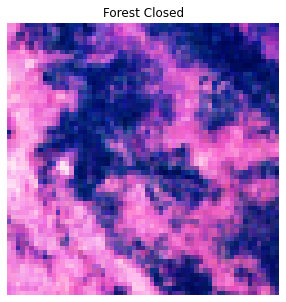

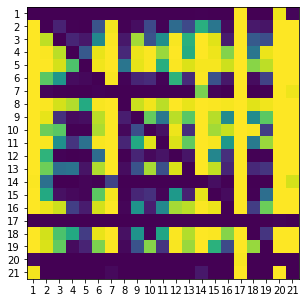

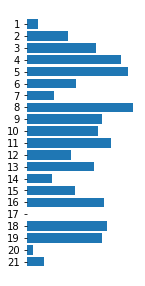

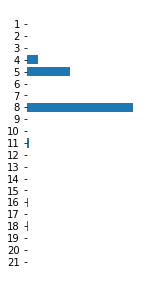

In [26]:
from skimage.exposure import equalize_hist

rgb = equalize_hist(x[0,np.array([3,2,1])].numpy())
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(rgb.transpose(1,2,0))
ax.axis("off")
ax.set_title(f"{CLASSNAMES[int(y)]}")

fig.savefig("/tmp/rgb.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=(5,5), frameon=False)
ax.imshow(scores_matrix)
ax.set_yticks(np.arange(21))
ax.set_yticklabels(np.arange(21)+1)
ax.set_xticks(np.arange(21))
ax.set_xticklabels(np.arange(21)+1)


fig.savefig("/tmp/matrix.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=(2,5), frameon=False)

#scores_ = torch.softmax(torch.tensor(scores_matrix).sum(1), dim=0)
scores_ = torch.tensor(scores_matrix).sum(1)
scores_ = torch.flip(scores_, (0,))
ax.barh(np.arange(scores_matrix.sum(1).shape[0]), width=scores_)
ax.set_yticks(np.arange(21))
ax.set_yticklabels(np.arange(1,22)[::-1])
ax.set_xticks([])
ax.set_xticklabels([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)


fig.savefig("/tmp/logits.png", dpi=300, bbox_inches="tight")

    
fig, ax = plt.subplots(figsize=(2,5), frameon=False)
scores_ = torch.softmax(torch.tensor(scores_matrix).sum(1), dim=0)
#scores_ = torch.tensor(scores_matrix).sum(1)
scores_ = torch.flip(scores_, (0,))
ax.barh(np.arange(scores_matrix.sum(1).shape[0]), width=scores_)
ax.set_yticks(np.arange(21))
ax.set_yticklabels(np.arange(1,22)[::-1])
ax.set_xticks([])
ax.set_xticklabels([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
fig.savefig("/tmp/probas.png", dpi=300, bbox_inches="tight")